# Basic setups

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import shutil
import random
import pprint
import itertools
import functools
import collections

import pysam
import pyranges as pr
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/users/pjh/scripts/python_genome_package_dev/')
sys.path.append('/home/users/pjh/scripts/encode_annotator')

In [2]:
from handygenome import common
from handygenome.common import ChromDict
from handygenome.variant.vcfspec import Vcfspec
from handygenome.sv.breakends import Breakends
from handygenome.variant.variantplus import VariantPlus, VariantPlusList
from handygenome.igvhandle import IGVHandle

[W::hts_idx_load3] The index file is older than the data file: /home/users/pjh/scripts/python_genome_packages/data/popfreq/dbSNP_b155_GRCh37.p13.vcf.gz.csi


In [3]:
FASTA_HG19 = common.DEFAULT_FASTAS['hg19']
FASTA_HG38 = common.DEFAULT_FASTAS['hg38']
CHROMDICT_HG19 = common.DEFAULT_CHROMDICTS['hg19']
CHROMDICT_HG38 = common.DEFAULT_CHROMDICTS['hg38']

In [4]:
igv = IGVHandle(60387)

# Main

### UniProt

In [61]:
# uniprot
url = """https://rest.uniprot.org/uniprotkb/search?\
query=accession:Q9UM73&\
fields=ft_region,ft_motif,ft_domain,ft_dna_bind,ft_binding\
"""

# EBI protein API
# url = 'https://www.ebi.ac.uk/proteins/api/features?accession=P04637&categories=DOMAINS_AND_SITES'

result = common.http_get(url)

In [62]:
result['results'][0]['primaryAccession']

'Q9UM73'

In [63]:
pprint.pprint(result)

{'results': [{'features': [{'description': 'MAM 1',
                            'evidences': [{'evidenceCode': 'ECO:0000255',
                                           'id': 'PRU00128',
                                           'source': 'PROSITE-ProRule'}],
                            'location': {'end': {'modifier': 'EXACT',
                                                 'value': 427},
                                         'start': {'modifier': 'EXACT',
                                                   'value': 264}},
                            'type': 'Domain'},
                           {'description': 'LDL-receptor class A',
                            'location': {'end': {'modifier': 'EXACT',
                                                 'value': 473},
                                         'start': {'modifier': 'EXACT',
                                                   'value': 437}},
                            'type': 'Domain'},
                           {'des

In [67]:
for x in sorted(
    result['results'][0]['features'], 
    key=(lambda y: (y['location']['start']['value'], y['location']['end']['value']))
):
    start1 = x['location']['start']['value']
    end1 = x['location']['end']['value']
    start0 = start1 - 1
    end0 = end1
    
    type = x['type']
    description = x['description']
    if 'ligand' in x:
        ligand = x['ligand']
    else:
        ligand = None
        
    data = dict()
    data['range0'] = range(start0, end0)
    data['type'] = x['type']
    data['description'] = x['description']
    if 'ligand' in x:
        data['ligand'] = x['ligand']['name']
    else:
        data['ligand'] = None    
    
    print(data)
    

{'range0': range(47, 70), 'type': 'Region', 'description': 'Heparin-binding region', 'ligand': None}
{'range0': range(263, 427), 'type': 'Domain', 'description': 'MAM 1', 'ligand': None}
{'range0': range(436, 473), 'type': 'Domain', 'description': 'LDL-receptor class A', 'ligand': None}
{'range0': range(477, 636), 'type': 'Domain', 'description': 'MAM 2', 'ligand': None}
{'range0': range(649, 674), 'type': 'Region', 'description': 'Disordered', 'ligand': None}
{'range0': range(986, 1025), 'type': 'Region', 'description': 'EGF-like', 'ligand': None}
{'range0': range(1115, 1392), 'type': 'Domain', 'description': 'Protein kinase', 'ligand': None}
{'range0': range(1123, 1124), 'type': 'Binding site', 'description': '', 'ligand': 'ATP'}
{'range0': range(1149, 1150), 'type': 'Binding site', 'description': '', 'ligand': 'ATP'}
{'range0': range(1196, 1199), 'type': 'Binding site', 'description': '', 'ligand': 'ATP'}
{'range0': range(1269, 1270), 'type': 'Binding site', 'description': '', 'liga

### ENCODE

In [5]:
import encode_annotator
import pyBigWig

In [118]:
organ_cCRE_info = encode_annotator.get_cCRE_info_organ('lung')

Found 21 annotation entries.
Searching for information about ENCSR923XTG
Searching for information about ENCSR294ZQN
Searching for information about ENCSR910TTG
Searching for information about ENCSR069FLL
Searching for information about ENCSR952CWN
Searching for information about ENCSR001XAE
Searching for information about ENCSR075TNF
Searching for information about ENCSR403JJV
Searching for information about ENCSR162HPD
Searching for information about ENCSR899LDE
Searching for information about ENCSR719YLV
Searching for information about ENCSR334ZEX
Searching for information about ENCSR113ZQN
Searching for information about ENCSR981OYL
Searching for information about ENCSR599BME
Searching for information about ENCSR782DTI
Searching for information about ENCSR813WZG
Searching for information about ENCSR345PVF
Searching for information about ENCSR112MKQ
Searching for information about ENCSR992ZDA
Searching for information about ENCSR623FDW


In [ ]:
gr_all_cCRE = encode_annotator.get_all_cCREs_gr()

In [148]:
infile_path = '/home/users/pjh/scripts/encode_annotator/test/input.tsv'
infile_df = pd.read_table(infile_path, comment='#', header=None)
infile_df = infile_df.iloc[:, :2]
infile_df.columns = ['CHROM', 'POS']

In [150]:
coord_list = [(row.iloc[0], row.iloc[1]) for idx, row in infile_df.iterrows()]

In [154]:
mutation_annotation_result = encode_annotator.annotate_mutations_with_cCREinfo(coord_list, gr_all_cCRE, organ_cCRE_info, dist=50)

In [157]:
cCRE_INFO_column = [
    json.dumps(mutation_annotation_result[f'{chrom}_{pos}'])
    for chrom, pos in coord_list
]

In [159]:
samples_metadata_strig = encode_annotator.serialize_samples_metadata(organ_cCRE_info)

In [6]:
encode_annotator.get_available_organs()

['adipose tissue',
 'adrenal gland',
 'arterial blood vessel',
 'blood',
 'blood vessel',
 'bodily fluid',
 'bone element',
 'bone marrow',
 'brain',
 'breast',
 'bronchus',
 'colon',
 'connective tissue',
 'ear',
 'embryo',
 'endocrine gland',
 'epithelium',
 'esophagus',
 'exocrine gland',
 'extraembryonic component',
 'eye',
 'gallbladder',
 'gonad',
 'heart',
 'immune organ',
 'intestine',
 'kidney',
 'large intestine',
 'limb',
 'liver',
 'lung',
 'lymph node',
 'lymphatic vessel',
 'lymphoid tissue',
 'mammary gland',
 'mouth',
 'mucous gland',
 'musculature of body',
 'nerve',
 'nose',
 'ovary',
 'pancreas',
 'paraythroid gland',
 'penis',
 'pericardium',
 'pituitary gland',
 'placenta',
 'prostate gland',
 'skeleton',
 'skin of body',
 'skin of prepuce of penis',
 'small intestine',
 'spinal cord',
 'spleen',
 'stomach',
 'testis',
 'thymus',
 'thyroid gland',
 'tongue',
 'trachea',
 'ureter',
 'urinary bladder',
 'uterus',
 'vagina',
 'vasculature',
 'vein']

In [125]:
coord_list = [
    ('chr7', 55_019_100),  # EGFR
    ('chr2', 209_579_500),  # MAP2
]

# dist = 50
# coords_gr = pr.from_dict({
#     'Chromosome': [x[0] for x in coord_list],
#     'Start': [x[1] - 1 - dist for x in coord_list],
#     'End': [x[1] + dist for x in coord_list],   
#     'Mutation_id': [f'{x[0]}_{x[1]}' for x in coord_list],
# })

In [131]:
mutation_annotation_result = common.annotate_mutations_with_cCREinfo(coord_list, gr_all_cCRE, organ_cCRE_info, dist=50)

In [ ]:
pprint.pprint(mutation_annotation_result)

{'chr2_209579500': {'EH38E2070794': {'chrom': 'chr2',
                                     'class': {'ENCSR001XAE': 'PLS',
                                               'ENCSR069FLL': 'Unclassified',
                                               'ENCSR075TNF': 'Low-DNase',
                                               'ENCSR112MKQ': 'Low-DNase',
                                               'ENCSR113ZQN': 'Low-DNase',
                                               'ENCSR162HPD': 'Low-DNase',
                                               'ENCSR294ZQN': 'Unclassified',
                                               'ENCSR334ZEX': 'DNase-only',
                                               'ENCSR345PVF': 'Unclassified',
                                               'ENCSR403JJV': 'High-H3K4me3',
                                               'ENCSR599BME': 'Low-DNase',
                                               'ENCSR623FDW': 'Unclassified',
                                    

In [163]:
outfile_path = '/home/users/pjh/scripts/encode_annotator/test/output.tsv'
outfile_df = pd.read_table(outfile_path)

In [164]:
import pandas as pd

outfile_df = pd.read_table('output.tsv')
outfile_df

,CHROM,POS,cCRE_INFO,SAMPLES_METADATA
0,chr7,55019100,"{""EH38E3775347"": {""start"": 55018749, ""end"": 55...","{""ENCSR923XTG"": {""cell_types"": [""connective ti..."
1,chr2,209579500,"{""EH38E2070794"": {""start"": 209579285, ""end"": 2...","{""ENCSR923XTG"": {""cell_types"": [""connective ti..."


In [165]:
import json
# selecting the first row
row1 = outfile_df.iloc[0, :]
# converting annotation string into dictionary
cCRE_info = json.loads(row1['cCRE_INFO'])
cCRE_info

{'EH38E3775347': {'start': 55018749,
  'end': 55019099,
  'chrom': 'chr7',
  'id': 'EH38E3775347',
  'class': {'all_samples': 'PLS,CTCF-bound',
   'ENCSR923XTG': 'High-H3K4me3,High-H3K27ac',
   'ENCSR294ZQN': 'High-H3K4me3',
   'ENCSR910TTG': 'DNase-only',
   'ENCSR069FLL': 'High-H3K4me3,High-H3K27ac',
   'ENCSR952CWN': 'DNase-only',
   'ENCSR001XAE': 'PLS',
   'ENCSR075TNF': 'DNase-only',
   'ENCSR403JJV': 'High-H3K4me3',
   'ENCSR162HPD': 'DNase-only',
   'ENCSR899LDE': 'PLS',
   'ENCSR719YLV': 'DNase-only',
   'ENCSR334ZEX': 'DNase-only',
   'ENCSR113ZQN': 'DNase-only',
   'ENCSR981OYL': 'PLS',
   'ENCSR599BME': 'DNase-only',
   'ENCSR782DTI': 'PLS',
   'ENCSR813WZG': 'PLS',
   'ENCSR345PVF': 'High-H3K4me3',
   'ENCSR112MKQ': 'PLS',
   'ENCSR992ZDA': 'PLS',
   'ENCSR623FDW': 'High-H3K4me3,High-H3K27ac'},
  'completeness': {'all_samples': None,
   'ENCSR923XTG': 'Missing-data/Partial-classification',
   'ENCSR294ZQN': 'Missing-data/Partial-classification',
   'ENCSR910TTG': 'Missing-

In [166]:
samples_metadata = json.loads(row1['SAMPLES_METADATA'])
samples_metadata

{'ENCSR923XTG': {'cell_types': ['connective tissue cell', 'fibroblast'],
  'sample_type': 'primary cell',
  'sample_name': 'fibroblast of lung'},
 'ENCSR294ZQN': {'cell_types': ['connective tissue cell', 'fibroblast'],
  'sample_type': 'cell line',
  'sample_name': 'WI38'},
 'ENCSR910TTG': {'cell_types': ['connective tissue cell', 'fibroblast'],
  'sample_type': 'cell line',
  'sample_name': 'WI38'},
 'ENCSR069FLL': {'cell_types': ['cancer cell'],
  'sample_type': 'cell line',
  'sample_name': 'A549'},
 'ENCSR952CWN': {'cell_types': ['endothelial cell', 'epithelial cell'],
  'sample_type': 'primary cell',
  'sample_name': 'lung microvascular endothelial cell'},
 'ENCSR001XAE': {'cell_types': ['connective tissue cell', 'fibroblast'],
  'sample_type': 'primary cell',
  'sample_name': 'fibroblast of lung'},
 'ENCSR075TNF': {'cell_types': ['connective tissue cell', 'fibroblast'],
  'sample_type': 'cell line',
  'sample_name': 'WI38'},
 'ENCSR403JJV': {'cell_types': ['connective tissue cell

In [99]:
# cCRE Annotation
params_cCRE = [
    ('limit', 'all', False),
    ('type', 'Annotation', False),
    ('encyclopedia_version', 'current', False),
    ('status', 'released', False),
    ('assembly', 'GRCh38', False),
    ('annotation_type', 'candidate Cis-Regulatory Elements', False),
    ('organism.scientific_name', 'Homo sapiens', False),
    ('biosample_ontology.organ_slims', 'lung', False),
    ('biosample_ontology.classification', 'primary cell', False),
    ('biosample_ontology.classification', 'cell line', False),
    ('biosample_ontology.classification', 'in vitro differentiated cells', False),
    ('biosample_ontology.classification', 'organoid', False),
]

params_repli = [
    ('limit', 'all', False),
    ('type', 'Experiment', False),
    # ('control_type', '*', True),
    ('status', 'released', False),
    ('perturbed', 'false', False),
    # ('assembly', 'GRCh38', False),
    ('assay_slims', 'Replication timing', False),
    ('replicates.library.biosample.donor.organism.scientific_name', 'Homo sapiens', False),
    ('replicates.library.biosample.disease_term_name', '*', True),
    ('biosample_ontology.organ_slims', 'lung', False),
    ('biosample_ontology.classification', 'primary cell', False),
    ('biosample_ontology.classification', 'cell line', False),
    ('biosample_ontology.classification', 'in vitro differentiated cells', False),
    ('biosample_ontology.classification', 'organoid', False),
]

params_dnase = [
    ('limit', 'all', False),
    ('type', 'Experiment', False),
    ('control_type', '*', True),
    ('status', 'released', False),
    ('perturbed', 'false', False),
    ('assembly', 'GRCh38', False),
    ('assay_title', 'DNase-seq', False),
    ('replicates.library.biosample.donor.organism.scientific_name', 'Homo sapiens', False),
    ('replicates.library.biosample.disease_term_name', '*', True),
    ('biosample_ontology.organ_slims', 'lung', False),
    ('biosample_ontology.classification', 'primary cell', False),
    ('biosample_ontology.classification', 'cell line', False),
    ('biosample_ontology.classification', 'in vitro differentiated cells', False),
    ('biosample_ontology.classification', 'organoid', False),
]

params_histone = [
    ('limit', 'all', False),
    ('type', 'Experiment', False),
    ('control_type', '*', True),
    ('status', 'released', False),
    ('perturbed', 'false', False),
    ('assembly', 'GRCh38', False),
    ('assay_title', 'Histone ChIP-seq', False),
    ('target.label', 'H3K27ac', False),
    ('replicates.library.biosample.donor.organism.scientific_name', 'Homo sapiens', False),
    ('replicates.library.biosample.disease_term_name', '*', True),
    ('biosample_ontology.organ_slims', 'lung', False),
    ('biosample_ontology.classification', 'primary cell', False),
    ('biosample_ontology.classification', 'cell line', False),
    ('biosample_ontology.classification', 'in vitro differentiated cells', False),
    ('biosample_ontology.classification', 'organoid', False),
]

params_tf = [
    ('limit', 'all', False),
    ('type', 'Experiment', False),
    ('control_type', '*', True),
    ('status', 'released', False),
    ('perturbed', 'false', False),
    ('assembly', 'GRCh38', False),
    ('assay_title', 'TF ChIP-seq', False),
    ('target.label', 'MAX', False),
    ('replicates.library.biosample.donor.organism.scientific_name', 'Homo sapiens', False),
    ('replicates.library.biosample.disease_term_name', '*', True),
    ('biosample_ontology.organ_slims', 'lung', False),
    ('biosample_ontology.classification', 'primary cell', False),
    ('biosample_ontology.classification', 'cell line', False),
    ('biosample_ontology.classification', 'in vitro differentiated cells', False),
    ('biosample_ontology.classification', 'organoid', False),
]


# ChIA-PET
url = """https://www.encodeproject.org/search/?\
limit=all&\
type=Experiment&\
control_type!=*&\
status=released&\
perturbed=false&\
assay_slims=3D+chromatin+structure&\
assay_title=ChIA-PET&\
replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&\
replicates.library.biosample.disease_term_name!=*&\
biosample_ontology.organ_slims=lung&\
biosample_ontology.classification=primary+cell&\
biosample_ontology.classification=cell+line&\
biosample_ontology.classification=in+vitro+differentiated+cells&\
biosample_ontology.classification=organoid\
"""

# Hi-C
url = """https://www.encodeproject.org/search/?\
limit=all&\
type=Experiment&\
control_type!=*&\
status=released&\
perturbed=false&\
assay_title=intact+Hi-C&\
assay_title=in+situ+Hi-C&\
replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&\
replicates.library.biosample.disease_term_name!=*&\
biosample_ontology.classification=tissue&\
biosample_ontology.classification=primary+cell&\
biosample_ontology.classification=cell+line&\
biosample_ontology.classification=in+vitro+differentiated+cells&\
biosample_ontology.classification=organoid\
"""

# biosample_ontology.organ_slims=lung&\


url = 'https://www.encodeproject.org/search/?' + encode_annotator.encode_urlparams(params_histone)

result = common.http_get(url)

# pprint.pprint(result['@graph'])

for x in result['@graph']:    
    accession = x["accession"]
    details = common.http_get(f'https://www.encodeproject.org/{accession}')
    
    # if not any(('subcompartments' in entry['output_type']) for entry in details['files']):
    #     continue
    
    print("======", accession, "======")
    print('assay_title:', details['assay_title'])
    print('biosample classification:', details['biosample_ontology']['classification'])
    print('cell_slims:', details['biosample_ontology']['cell_slims'])
    print('organ_slims:', details['biosample_ontology']['organ_slims'])
    print('biosample title:', details['biosample_ontology']['term_name'])
    print('biosample_summary:', details['biosample_summary'])
    if 'target' in details:
        print('target:', details['target']['title'])
    
    print()
    
    for entry in details['files']:        
        # if 'preferred_default' in entry:
        #     if not entry['preferred_default']:
        #         continue
        # else:
        #     continue
        
        print('file accession:', entry['accession'])
        print('donors:', entry['donors'])
        print('simple_biosample_summary:', entry['simple_biosample_summary'])
        print('href:', entry['href'])
        print('file_type:', entry['file_type'])
        print('output_type:', entry['output_type'])
        if 'preferred_default' in entry:
            print('preferred_default:', entry['preferred_default'])
        print('-----')
        
    print()
    print()
        

====== ENCSR778NQS ======
assay_title: Histone ChIP-seq
biosample classification: cell line
cell_slims: ['cancer cell']
organ_slims: ['lung']
biosample title: A549
biosample_summary: Homo sapiens A549
target: H3K27ac (Homo sapiens)

file accession: ENCFF743HCC
donors: ['/human-donors/ENCDO000AAZ/']
simple_biosample_summary: 
href: /files/ENCFF743HCC/@@download/ENCFF743HCC.bigWig
file_type: bigWig
output_type: signal p-value
-----
file accession: ENCFF236PNO
donors: ['/human-donors/ENCDO000AAZ/']
simple_biosample_summary: 
href: /files/ENCFF236PNO/@@download/ENCFF236PNO.bam
file_type: bam
output_type: alignments
-----
file accession: ENCFF808SQL
donors: ['/human-donors/ENCDO000AAZ/']
simple_biosample_summary: 
href: /files/ENCFF808SQL/@@download/ENCFF808SQL.bam
file_type: bam
output_type: alignments
-----
file accession: ENCFF897YZE
donors: ['/human-donors/ENCDO000AAZ/']
simple_biosample_summary: 
href: /files/ENCFF897YZE/@@download/ENCFF897YZE.bam
file_type: bam
output_type: alignments

In [77]:
pprint.pprint(common.http_get(f'https://www.encodeproject.org/ENCSR852KQC')['biosample_ontology'])

{'@id': '/biosample-types/cell_line_EFO_0001196/',
 '@type': ['BiosampleType', 'Item'],
 'aliases': ['encode:IMR-90'],
 'cell_slims': ['connective tissue cell', 'fibroblast'],
 'classification': 'cell line',
 'dbxrefs': ['Cellosaurus:CVCL_0347'],
 'developmental_slims': ['endoderm'],
 'name': 'cell_line_EFO_0001196',
 'organ_slims': ['connective tissue', 'lung'],
 'references': [],
 'schema_version': '1',
 'status': 'released',
 'synonyms': ['IMR90'],
 'system_slims': ['respiratory system'],
 'term_id': 'EFO:0001196',
 'term_name': 'IMR-90',
 'uuid': '020db017-aff3-47cc-9f63-b109d03d1577'}


In [201]:
url = 'https://www.encodeproject.org/ENCSR946LTR'
result = common.http_get(url)

# pprint.pprint(result['files'][0])
for x in result['files']:
    print(x['href'], x['file_type'], x['output_type'])

/files/ENCFF561VHA/@@download/ENCFF561VHA.fastq.gz fastq reads
/files/ENCFF613HQY/@@download/ENCFF613HQY.fastq.gz fastq reads
/files/ENCFF118EUG/@@download/ENCFF118EUG.fastq.gz fastq reads
/files/ENCFF318TTK/@@download/ENCFF318TTK.fastq.gz fastq reads
/files/ENCFF943KFY/@@download/ENCFF943KFY.fastq.gz fastq reads
/files/ENCFF024YQA/@@download/ENCFF024YQA.fastq.gz fastq reads
/files/ENCFF558WXJ/@@download/ENCFF558WXJ.fastq.gz fastq reads
/files/ENCFF904FBS/@@download/ENCFF904FBS.fastq.gz fastq reads
/files/ENCFF484VRJ/@@download/ENCFF484VRJ.bam bam alignments
/files/ENCFF157HOG/@@download/ENCFF157HOG.bam bam unfiltered alignments
/files/ENCFF243CHP/@@download/ENCFF243CHP.bed.gz bed narrowPeak pseudoreplicated peaks
/files/ENCFF792SZA/@@download/ENCFF792SZA.bigWig bigWig fold change over control
/files/ENCFF436QQK/@@download/ENCFF436QQK.bigWig bigWig signal p-value
/files/ENCFF975KXU/@@download/ENCFF975KXU.bigBed bigBed narrowPeak pseudoreplicated peaks


In [7]:
import time
file_url = 'https://www.encodeproject.org/' + '/files/ENCFF864JGJ/@@download/ENCFF864JGJ.bigWig'
print(file_url, flush=True)

bw = pyBigWig.open(file_url)
# df = pd.read_table(file_url, header=None)

https://www.encodeproject.org//files/ENCFF864JGJ/@@download/ENCFF864JGJ.bigWig


# Calculating global mean and std from bigwig file

In [6]:
def combined_mean_std(tup1, tup2):
    n1, m1, s1 = tup1
    n2, m2, s2 = tup2
    
    n = n1 + n2
    m = (n1 * m1 + n2 * m2) / n
    
    num1 = n1 * (s1 ** 2)
    num2 = n2 * (s2 ** 2)
    num3 = n1 * ((m1 - m) ** 2)
    num4 = n2 * ((m2 - m) ** 2)
    num = (num1 + num2 + num3 + num4)
    den = n
    s = np.sqrt(num / den)
    
    return n, m, s

In [8]:
import time
file_url = 'https://www.encodeproject.org/' + '/files/ENCFF864JGJ/@@download/ENCFF864JGJ.bigWig'
print(file_url, flush=True)

bw = pyBigWig.open(file_url)
# df = pd.read_table(file_url, header=None)

https://www.encodeproject.org//files/ENCFF864JGJ/@@download/ENCFF864JGJ.bigWig


In [9]:
tup1 = (bw.chroms()['chr1'], bw.stats('chr1', type='mean')[0], bw.stats('chr1', type='std')[0])
tup2 = (bw.chroms()['chr2'], bw.stats('chr2', type='mean')[0], bw.stats('chr2', type='std')[0])

In [10]:
combined_mean_std(tup1, tup2)

(491149951, 0.6485789664904461, 1.3078553923680123)

In [11]:
import functools
gen = (
    (length, bw.stats(chrom, type='mean')[0], bw.stats(chrom, type='std')[0])
    for chrom, length in bw.chroms().items()
)
n, mean, std = functools.reduce(combined_mean_std, gen)

In [17]:
max_z_score = max(
    (bw.stats(chrom, type='max')[0] - mean) / std
    for chrom in bw.chroms().keys()
)

min_z_score = min(
    (bw.stats(chrom, type='min')[0] - mean) / std
    for chrom in bw.chroms().keys()
)

In [18]:
max_z_score, min_z_score

(29.646143272123066, -0.46334478321425365)

In [7]:
bw = pyBigWig.open('/home/users/pjh/tmp/encode_data/ENCFF792SZA.bigWig')

In [10]:
import itertools
gen = itertools.chain.from_iterable(
    ((chrom, x[0], x[1], x[2]) for x in bw.intervals(chrom))
    for chrom in bw.chroms().keys()
)
df = pd.DataFrame.from_records(gen, columns=['Chromosome', 'Start', 'End', 'Value'])

In [11]:
df

,Chromosome,Start,End,Value
0,chr1,0,12937,0.00000
1,chr1,12937,12945,0.39193
2,chr1,12945,13127,0.78386
3,chr1,13127,13135,0.39193
4,chr1,13135,13173,0.00000
...,...,...,...,...
133081211,chrY,56885623,56885709,0.39193
133081212,chrY,56885709,56885871,0.00000
133081213,chrY,56885871,56886061,0.39193
133081214,chrY,56886061,56886608,0.00000


In [189]:
import collections

df = pd.read_table(
    '/home/users/pjh/tmp/encode_data/ENCFF243CHP.bed.gz', 
    header=None, 
)

In [190]:
df

,0,1,2,3,4,5,6,7,8,9
0,chr1,10000365,10001751,Peak_21046,179,.,5.93976,17.94231,15.66239,674
1,chr1,100033474,100036469,Peak_13075,298,.,9.62066,29.85493,27.24606,1482
2,chr1,100036769,100039468,Peak_634,1000,.,27.38581,124.74894,120.25225,1461
3,chr1,100039912,100040426,Peak_69126,65,.,3.57985,6.56185,4.75965,68
4,chr1,100076962,100078153,Peak_68249,66,.,3.39415,6.60683,4.80070,757
...,...,...,...,...,...,...,...,...,...,...
95641,chrX,9912279,9912865,Peak_37374,104,.,5.34983,10.40521,8.38851,339
95642,chrX,9927654,9927926,Peak_31029,122,.,5.91297,12.22048,10.12991,128
95643,chrX,9939630,9940162,Peak_118204,48,.,3.37884,4.81371,3.13688,174
95644,chrX,9940712,9941146,Peak_65213,70,.,4.22355,7.04808,5.21041,186


In [198]:
bam_path = '/home/users/pjh/tmp/encode_data/ENCFF484VRJ.bam'
igv.load([bam_path])

OK


In [199]:
row = df.iloc[0, :]
igv.goto([(row[0], row[1], row[2])])

OK


# Hi-C

In [290]:
import hicstraw

In [307]:
hic = hicstraw.HiCFile("https://www.encodeproject.org/files/ENCFF718AWL/@@download/ENCFF718AWL.hic")

In [319]:
matrix_object_chr4 = hic.getMatrixZoomData('4', '4', "observed", "KR", "BP", 5000)

In [320]:
numpy_matrix_chr4 = matrix_object_chr4.getRecordsAsMatrix(10000000, 12000000, 10000000, 12000000)

In [325]:
numpy_matrix_chr4.max()

1606.422119140625

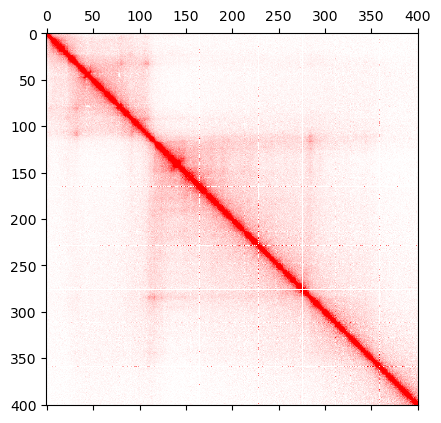

In [329]:
from matplotlib.colors import LinearSegmentedColormap
REDMAP = LinearSegmentedColormap.from_list("bright_red", [(1,1,1),(1,0,0)])

plt.matshow(numpy_matrix_chr4, cmap=REDMAP, vmax=70)